## Цели практической работы

* Изучить и предобработать данные в задаче оттока.

* Научиться применять для решения задачи решающие деревья и оценивать результаты модели.

## Описание (сделела для себя для лучего понимания данных):
- State(Штат место проживания клиента)
- Account length (Длина счета в месяцах)
- Area code(Код города)
- International plan (Международный план Yes - есть, No - нет)
- Voice mail plan (План голосовой почты Yes - есть, No - нет)
- Number vmail messages (Количество сообщений vmail)
- Total day minutes(Общее количество минут в день)
- Total day calls(Всего звонков за день)
- Total day charge(Общая стоимость дня)
- Total eve minutes(Общее количество минут накануне)
- Total eve calls(Всего вызовов накануне)
- Total eve charge(Общие расходы на канунe)
- Total night minutes(Всего ночных минут)
- Total night calls(Всего ночных звонков)
- Total night charge(Общая стоимость за ночь)
- Total intl calls(Общее количество международных минут)
- Total intl calls(Всего международных вызовов)
- Total intl charge(Общая стоимость международного трансфера)
- Customer service calls(Звонки в службу поддержки клиентов)
- Отток (True - клиент ушел, False - клиент остался)


## Что входит в практическую работу

*  Загрузка и предобработка данных.
*  Применение и настройка линейных моделей.
*  Применение и настройка решающего дерева.
*  Сравнение моделей.
*  Оценка важности признаков.

## Что оценивается

Выполнены все задания ноутбука (заполнены пустые ячейки, даны ответы на вопросы).

## Что нужно сделать
Решите задачу классификации оттоковых клиентов телекома: для каждого клиента необходимо определить, перестанет он пользоваться услугами оператора в ближайшее время или нет.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
%pip install shap

  Using cached shap-0.46.0-cp311-cp311-win_amd64.whl.metadata (25 kB)
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
Using cached shap-0.46.0-cp311-cp311-win_amd64.whl (456 kB)
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
import shap

np.random.seed(101)
shap.initjs()

In [4]:
sns.set(style="ticks") # эта функция меняет глобальные переменные: все последующие графики отрисовываются в том же стиле.
plt.rc('figure', figsize=(18, 6)) # устанавливаем размеры графиков по умолчанию
pd.set_option('display.max_columns', 100) # настроим показ максимального количества столбцов

In [5]:
df = pd.read_csv('telecom_churn.csv')
df.head().T

,0,1,2,3,4
State,KS,OH,NJ,OH,OK
Account length,128,107,137,84,75
Area code,415,415,415,408,415
International plan,No,No,No,Yes,Yes
Voice mail plan,Yes,Yes,No,No,No
Number vmail messages,25,26,0,0,0
Total day minutes,265.1,161.6,243.4,299.4,166.7
Total day calls,110,123,114,71,113
Total day charge,45.07,27.47,41.38,50.9,28.34
Total eve minutes,197.4,195.5,121.2,61.9,148.3


Сделайте первичную обработку данных:

1. Выбросите колонку State.

2. Колонки International plan и Voice mail plan закодируйте следующим образом: Yes замените на 1, а No на 0.

3. Переведите целевую переменную (Churn) в числа: True в 1, а False в 0.

In [6]:
df_new = df.copy()
df_new.columns = df_new.columns.str.lower().str.replace(' ', '_')
df_new

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,No,Yes,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,No,No,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,No,No,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,Yes,No,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


In [7]:
df_new.isnull().sum()

state                     0
account_length            0
area_code                 0
international_plan        0
voice_mail_plan           0
number_vmail_messages     0
total_day_minutes         0
total_day_calls           0
total_day_charge          0
total_eve_minutes         0
total_eve_calls           0
total_eve_charge          0
total_night_minutes       0
total_night_calls         0
total_night_charge        0
total_intl_minutes        0
total_intl_calls          0
total_intl_charge         0
customer_service_calls    0
churn                     0
dtype: int64

In [8]:
df_new['voice_mail_plan'].loc[df_new['voice_mail_plan'] == 'No'] = 0
df_new['voice_mail_plan'].loc[df_new['voice_mail_plan'] == 'Yes'] = 1
df_new['voice_mail_plan'] = df_new['voice_mail_plan'].astype(int)
df_new['voice_mail_plan']

0       1
1       1
2       0
3       0
4       0
       ..
3328    1
3329    0
3330    0
3331    0
3332    1
Name: voice_mail_plan, Length: 3333, dtype: int32

In [9]:
df_new['international_plan'].loc[df_new['international_plan'] == 'No'] = 0
df_new['international_plan'].loc[df_new['international_plan'] == 'Yes'] = 1
df_new['international_plan'] = df_new['international_plan'].astype(int)
df_new['international_plan']

0       0
1       0
2       0
3       1
4       1
       ..
3328    0
3329    0
3330    0
3331    1
3332    0
Name: international_plan, Length: 3333, dtype: int32

In [10]:
df_new['churn'] = df_new['churn'].astype(int)

In [11]:
df_new.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,KS,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [12]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account_length          3333 non-null   int64  
 2   area_code               3333 non-null   int64  
 3   international_plan      3333 non-null   int32  
 4   voice_mail_plan         3333 non-null   int32  
 5   number_vmail_messages   3333 non-null   int64  
 6   total_day_minutes       3333 non-null   float64
 7   total_day_calls         3333 non-null   int64  
 8   total_day_charge        3333 non-null   float64
 9   total_eve_minutes       3333 non-null   float64
 10  total_eve_calls         3333 non-null   int64  
 11  total_eve_charge        3333 non-null   float64
 12  total_night_minutes     3333 non-null   float64
 13  total_night_calls       3333 non-null   int64  
 14  total_night_charge      3333 non-null   

In [13]:
df_new = df_new.drop(columns=["state"], axis=1)

Выведите на экран первые строки изменённой таблицы, чтобы проверить, что все преобразования сработали.

In [17]:
# ваш код здесь
df_new.head()

,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn,servicesAvailed_years
0,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0,11.0
1,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0,9.0
2,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,11.0
3,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0,7.0
4,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0,6.0


У нас есть признак account_length (длина счета клиентав в месяцах), которая сообщает нам количество месяцев, в течение которых клиент пользовался услугами. Мы создаем новый столбец с указанием количества использованных услуг в годах.

In [18]:
df_new['servicesAvailed_years'] = round((df_new['account_length']/12),0)
df_new['servicesAvailed_years']

0       11.0
1        9.0
2       11.0
3        7.0
4        6.0
        ... 
3328    16.0
3329     6.0
3330     2.0
3331    15.0
3332     6.0
Name: servicesAvailed_years, Length: 3333, dtype: float64

In [19]:
df_new.describe()

,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn,servicesAvailed_years
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,0.096910,0.276628,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856,0.144914,8.415842
std,39.822106,42.371290,0.295879,0.447398,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491,0.352067,3.328983
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,0.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000,0.000000,6.000000
50%,101.000000,415.000000,0.000000,0.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000,0.000000,8.000000
75%,127.000000,510.000000,0.000000,1.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000,0.000000,11.000000
max,243.000000,510.000000,1.000000,1.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000,1.000000,20.000000


Визуализируем матрицы корреляции между признаками и с целевой переменной

<Axes: >

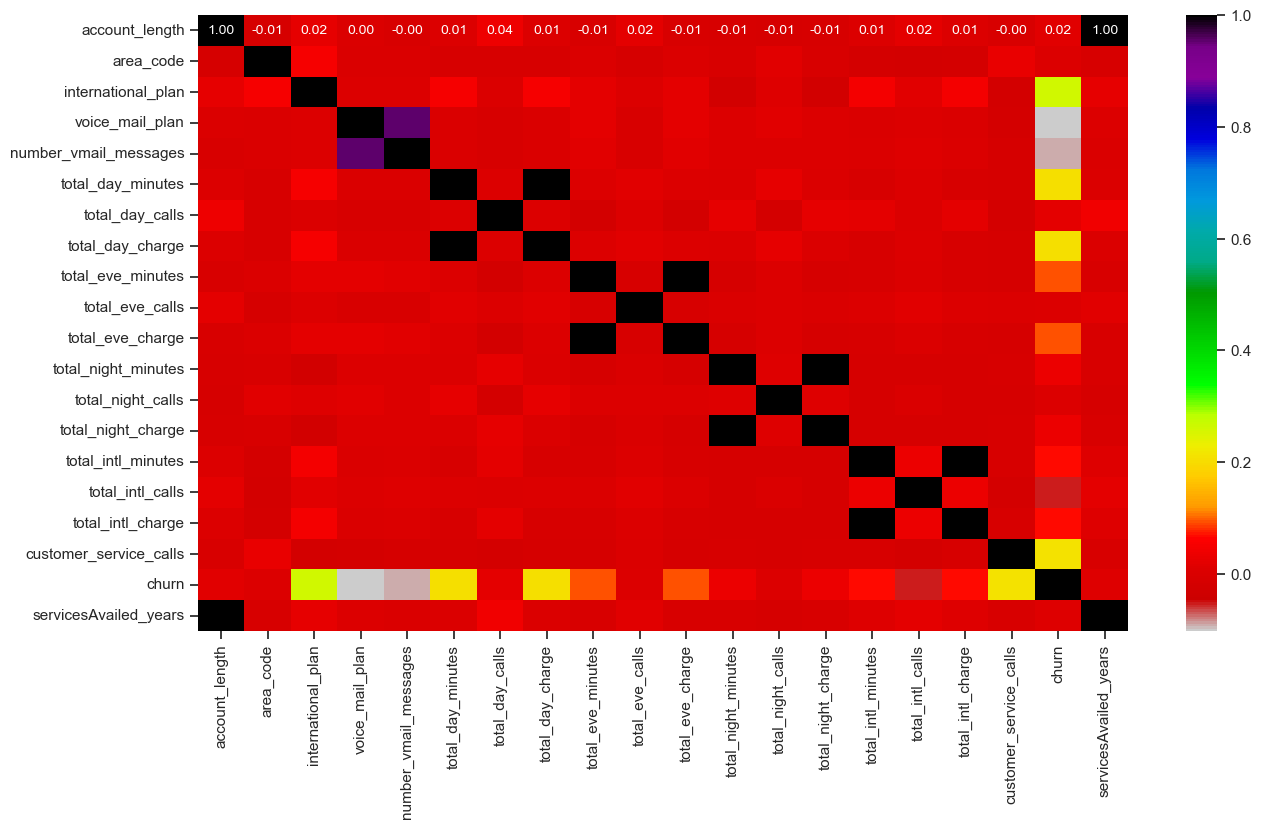

In [20]:
from matplotlib.pyplot import figure
figure(figsize=(15,8))
sns.heatmap(df_new.corr(), xticklabels=df_new.columns.values, yticklabels=df_new.columns.values,
            annot=True, cmap="nipy_spectral_r",annot_kws={'size': 10},fmt=".2f")

Мы наблюдаем, что стоимость звонков коррелирует с некоторыми другими признаками, такими как расходы на звонки и минуты (день, вечер, ночь) и т. д. Поэтому мы рассчитываем тарифы на звонки и удаляем столбцы этих расходов из набора данных. . Этот шаг призван решить проблему мультиколлинеарности, которая может оказаться полезной.

In [21]:
df_new['day_rate'] = df_new['total_day_charge'] / df_new['total_day_minutes']
df_new['eve_rate'] = df_new['total_eve_charge'] / df_new['total_eve_minutes']
df_new['night_rate'] = df_new['total_night_charge'] / df_new['total_night_minutes']
df_new['intl_rate'] = df_new['total_intl_charge'] / df_new['total_intl_minutes']

Наблюдается сильная кореляция между признакам international_plan(наличие международного плана) и voice_mail_plan(наличие плана голосовой почты). При этом с целевой переменной у этих признаков противоположная корреляция

In [22]:
df_new.drop({'total_day_charge','total_eve_charge','total_night_charge', 'total_intl_charge', 'account_length'}, axis=1,inplace=True)

In [23]:
df_new.isnull().sum()

area_code                  0
international_plan         0
voice_mail_plan            0
number_vmail_messages      0
total_day_minutes          0
total_day_calls            0
total_eve_minutes          0
total_eve_calls            0
total_night_minutes        0
total_night_calls          0
total_intl_minutes         0
total_intl_calls           0
customer_service_calls     0
churn                      0
servicesAvailed_years      0
day_rate                   2
eve_rate                   1
night_rate                 0
intl_rate                 18
dtype: int64

In [24]:
df_new[['day_rate', 'eve_rate', 'intl_rate']] = df_new[['day_rate', 'eve_rate', 'intl_rate']]. fillna(0)

In [25]:
df_new.isnull().sum()

area_code                 0
international_plan        0
voice_mail_plan           0
number_vmail_messages     0
total_day_minutes         0
total_day_calls           0
total_eve_minutes         0
total_eve_calls           0
total_night_minutes       0
total_night_calls         0
total_intl_minutes        0
total_intl_calls          0
customer_service_calls    0
churn                     0
servicesAvailed_years     0
day_rate                  0
eve_rate                  0
night_rate                0
intl_rate                 0
dtype: int64

<Axes: >

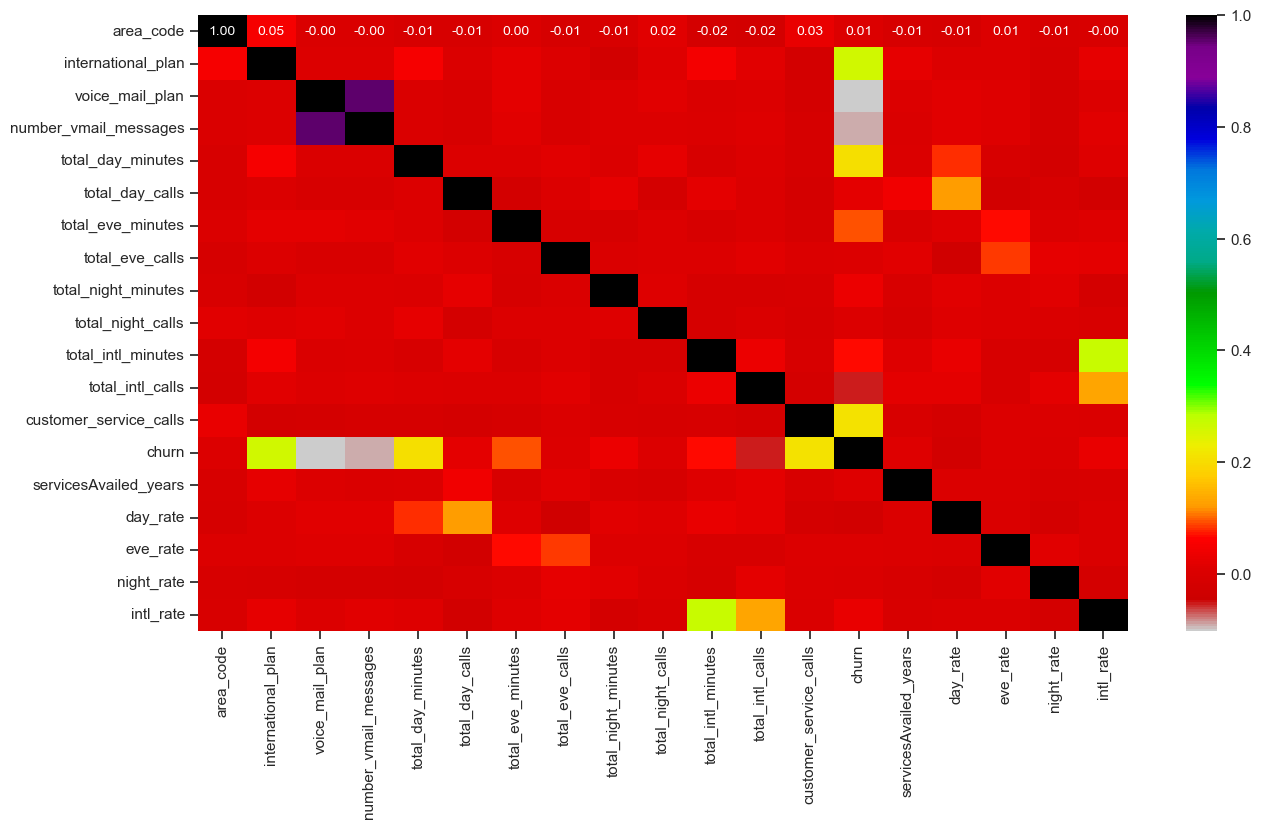

In [26]:
from matplotlib.pyplot import figure
figure(figsize=(15,8))
sns.heatmap(df_new.corr(), xticklabels=df_new.columns.values, yticklabels=df_new.columns.values,
            annot=True, cmap="nipy_spectral_r",annot_kws={'size': 10},fmt=".2f")

Сохраним преобразования в новый файл для маштабирования признаков и моделирования

In [27]:
df_new.to_csv('telecom_final.csv', index = False)

Загрузим преобразованный файл

In [28]:
df_final = pd.read_csv('telecom_final.csv')

In [29]:
df_final

,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,customer_service_calls,churn,servicesAvailed_years,day_rate,eve_rate,night_rate,intl_rate
0,415,0,1,25,265.1,110,197.4,99,244.7,91,10.0,3,1,0,11.0,0.170011,0.085005,0.044994,0.270000
1,415,0,1,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0,9.0,0.169988,0.085013,0.045008,0.270073
2,415,0,0,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0,11.0,0.170008,0.084983,0.045018,0.269672
3,408,1,0,0,299.4,71,61.9,88,196.9,89,6.6,7,2,0,7.0,0.170007,0.084976,0.044997,0.269697
4,415,1,0,0,166.7,113,148.3,122,186.9,121,10.1,3,3,0,6.0,0.170006,0.085030,0.044997,0.270297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,415,0,1,36,156.2,77,215.5,126,279.1,83,9.9,6,2,0,16.0,0.169974,0.085012,0.045002,0.269697
3329,415,0,0,0,231.1,57,153.4,55,191.3,123,9.6,4,3,0,6.0,0.170013,0.085007,0.045008,0.269792
3330,510,0,0,0,180.8,109,288.8,58,191.9,91,14.1,6,2,0,2.0,0.170022,0.085007,0.045023,0.270213
3331,510,1,0,0,213.8,105,159.6,84,139.2,137,5.0,10,2,0,15.0,0.170019,0.085025,0.044971,0.270000


In [30]:
df_final.isnull().sum()

area_code                 0
international_plan        0
voice_mail_plan           0
number_vmail_messages     0
total_day_minutes         0
total_day_calls           0
total_eve_minutes         0
total_eve_calls           0
total_night_minutes       0
total_night_calls         0
total_intl_minutes        0
total_intl_calls          0
customer_service_calls    0
churn                     0
servicesAvailed_years     0
day_rate                  0
eve_rate                  0
night_rate                0
intl_rate                 0
dtype: int64

Создайте матрицу объект-признак X и вектор с целевой переменной (Churn) y.

In [31]:
X_ALL = df_final.drop('churn', axis=1)
y = df_final['churn']
X_ALL

,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,customer_service_calls,servicesAvailed_years,day_rate,eve_rate,night_rate,intl_rate
0,415,0,1,25,265.1,110,197.4,99,244.7,91,10.0,3,1,11.0,0.170011,0.085005,0.044994,0.270000
1,415,0,1,26,161.6,123,195.5,103,254.4,103,13.7,3,1,9.0,0.169988,0.085013,0.045008,0.270073
2,415,0,0,0,243.4,114,121.2,110,162.6,104,12.2,5,0,11.0,0.170008,0.084983,0.045018,0.269672
3,408,1,0,0,299.4,71,61.9,88,196.9,89,6.6,7,2,7.0,0.170007,0.084976,0.044997,0.269697
4,415,1,0,0,166.7,113,148.3,122,186.9,121,10.1,3,3,6.0,0.170006,0.085030,0.044997,0.270297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,415,0,1,36,156.2,77,215.5,126,279.1,83,9.9,6,2,16.0,0.169974,0.085012,0.045002,0.269697
3329,415,0,0,0,231.1,57,153.4,55,191.3,123,9.6,4,3,6.0,0.170013,0.085007,0.045008,0.269792
3330,510,0,0,0,180.8,109,288.8,58,191.9,91,14.1,6,2,2.0,0.170022,0.085007,0.045023,0.270213
3331,510,1,0,0,213.8,105,159.6,84,139.2,137,5.0,10,2,15.0,0.170019,0.085025,0.044971,0.270000


In [32]:
X_ALL['area_code'].nunique()

3

In [33]:
area_code_dummies = pd.get_dummies(X_ALL['area_code'])
area_code_dummies = area_code_dummies.add_prefix('area_code_')
area_code_dummies = area_code_dummies.astype(int)
area_code_dummies

,area_code_408,area_code_415,area_code_510
0,0,1,0
1,0,1,0
2,0,1,0
3,1,0,0
4,0,1,0
...,...,...,...
3328,0,1,0
3329,0,1,0
3330,0,0,1
3331,0,0,1


In [34]:
X_ALL_new = pd.concat([X_ALL, area_code_dummies], axis=1)
X_ALL_new

,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,customer_service_calls,servicesAvailed_years,day_rate,eve_rate,night_rate,intl_rate,area_code_408,area_code_415,area_code_510
0,415,0,1,25,265.1,110,197.4,99,244.7,91,10.0,3,1,11.0,0.170011,0.085005,0.044994,0.270000,0,1,0
1,415,0,1,26,161.6,123,195.5,103,254.4,103,13.7,3,1,9.0,0.169988,0.085013,0.045008,0.270073,0,1,0
2,415,0,0,0,243.4,114,121.2,110,162.6,104,12.2,5,0,11.0,0.170008,0.084983,0.045018,0.269672,0,1,0
3,408,1,0,0,299.4,71,61.9,88,196.9,89,6.6,7,2,7.0,0.170007,0.084976,0.044997,0.269697,1,0,0
4,415,1,0,0,166.7,113,148.3,122,186.9,121,10.1,3,3,6.0,0.170006,0.085030,0.044997,0.270297,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,415,0,1,36,156.2,77,215.5,126,279.1,83,9.9,6,2,16.0,0.169974,0.085012,0.045002,0.269697,0,1,0
3329,415,0,0,0,231.1,57,153.4,55,191.3,123,9.6,4,3,6.0,0.170013,0.085007,0.045008,0.269792,0,1,0
3330,510,0,0,0,180.8,109,288.8,58,191.9,91,14.1,6,2,2.0,0.170022,0.085007,0.045023,0.270213,0,0,1
3331,510,1,0,0,213.8,105,159.6,84,139.2,137,5.0,10,2,15.0,0.170019,0.085025,0.044971,0.270000,0,0,1


In [35]:
X_ALL_new.drop({'area_code'}, axis=1,inplace=True)

In [36]:
X_ALL_new

,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,customer_service_calls,servicesAvailed_years,day_rate,eve_rate,night_rate,intl_rate,area_code_408,area_code_415,area_code_510
0,0,1,25,265.1,110,197.4,99,244.7,91,10.0,3,1,11.0,0.170011,0.085005,0.044994,0.270000,0,1,0
1,0,1,26,161.6,123,195.5,103,254.4,103,13.7,3,1,9.0,0.169988,0.085013,0.045008,0.270073,0,1,0
2,0,0,0,243.4,114,121.2,110,162.6,104,12.2,5,0,11.0,0.170008,0.084983,0.045018,0.269672,0,1,0
3,1,0,0,299.4,71,61.9,88,196.9,89,6.6,7,2,7.0,0.170007,0.084976,0.044997,0.269697,1,0,0
4,1,0,0,166.7,113,148.3,122,186.9,121,10.1,3,3,6.0,0.170006,0.085030,0.044997,0.270297,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,0,1,36,156.2,77,215.5,126,279.1,83,9.9,6,2,16.0,0.169974,0.085012,0.045002,0.269697,0,1,0
3329,0,0,0,231.1,57,153.4,55,191.3,123,9.6,4,3,6.0,0.170013,0.085007,0.045008,0.269792,0,1,0
3330,0,0,0,180.8,109,288.8,58,191.9,91,14.1,6,2,2.0,0.170022,0.085007,0.045023,0.270213,0,0,1
3331,1,0,0,213.8,105,159.6,84,139.2,137,5.0,10,2,15.0,0.170019,0.085025,0.044971,0.270000,0,0,1


В наших данных у всех признаков есть хвосты(выбросы). Качество моделей  LinearRegression и SVС сильно зависят от наличия выбросов. Для устрaнения выбросов применим метод масштабирования по медиане RobustScaler и до разделения данных на обучаемую(train) и тестовую(test).

In [37]:
Rb_scaler = RobustScaler()
data_rb = Rb_scaler.fit_transform(X_ALL_new)
X_ALL_scaler = pd.DataFrame(data_rb, columns=X_ALL_new.columns)

In [38]:
X_ALL_scaler

,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,customer_service_calls,servicesAvailed_years,day_rate,eve_rate,night_rate,intl_rate,area_code_408,area_code_415,area_code_510
0,0.0,1.0,1.25,1.178817,0.333333,-0.058224,-0.037037,0.636896,-0.346154,-0.083333,-0.333333,0.0,0.6,0.259143,0.202436,-0.250992,0.000000,0.0,1.0,0.0
1,0.0,1.0,1.30,-0.244842,0.814815,-0.085881,0.111111,0.778917,0.115385,0.944444,-0.333333,0.0,0.2,-0.596087,0.511010,0.321896,0.150281,0.0,1.0,0.0
2,0.0,0.0,0.00,0.880330,0.481481,-1.167394,0.370370,-0.565154,0.153846,0.527778,0.333333,-1.0,0.6,0.147259,-0.659422,0.755445,-0.675032,0.0,1.0,0.0
3,1.0,0.0,0.00,1.650619,-1.111111,-2.030568,-0.444444,-0.062958,-0.423077,-1.027778,1.000000,1.0,-0.2,0.091782,-0.968359,-0.103974,-0.623893,1.0,0.0,0.0
4,1.0,0.0,0.00,-0.174691,0.444444,-0.772926,0.814815,-0.209370,0.807692,-0.055556,-0.333333,2.0,-0.4,0.067192,1.212571,-0.109538,0.611538,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,0.0,1.0,1.80,-0.319120,-0.888889,0.205240,0.962963,1.140556,-0.653846,-0.111111,0.666667,1.0,1.6,-1.073718,0.463584,0.073352,-0.623893,0.0,1.0,0.0
3329,0.0,0.0,0.00,0.711142,-1.629630,-0.698690,-1.666667,-0.144949,0.884615,-0.194444,0.000000,2.0,-0.4,0.319241,0.260502,0.321054,-0.428926,0.0,1.0,0.0
3330,0.0,0.0,0.00,0.019257,0.296296,1.272198,-1.555556,-0.136164,-0.346154,1.055556,0.666667,1.0,-1.2,0.649255,0.276738,0.960151,0.438052,0.0,0.0,1.0
3331,1.0,0.0,0.00,0.473177,0.148148,-0.608443,-0.592593,-0.907760,1.423077,-1.472222,2.000000,1.0,1.4,0.525992,1.001527,-1.176584,0.000000,0.0,0.0,1.0


Проверьте баланс классов. Является ли выборка сбалансированной?

In [39]:
# ваш код здесь
global_mean = df_final.churn.mean()
round(global_mean, 3)

0.145

Вывод: В нашем наборе данных оказалось 14,5% данных в целевой переменной (churn)класса 1, класс 0 доминирует над классом 1.

Разбейте данные на тренировочную и тестовую части, размер тестовой части — 30%.

In [40]:
X = X_ALL_scaler.copy()
y = y.copy()

In [41]:
from sklearn.model_selection import train_test_split

# ваш код здесь
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.7, random_state=42)

Для линейных моделей очень важно масштабирование признаков. Поэтому отмасштабируйте признаки при помощи [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), обучив метод на тренировочных данных и применив его и к трейну, и к тесту.

!!!!!!!Я масштабировала признаки при помощи RobustScaler!!!!

In [42]:
from sklearn.preprocessing import StandardScaler

# ваш код здесь


После масштабирования признаков X_train и X_test перестали быть объектами типа pd.DataFrame, это неудобно. Приведите их снова к pd.DataFrame.

In [43]:
# ваш код здесь
# смотри выше X_ALL_scaler без разбиения

Обучите на тренировочных данных с параметрами по умолчанию:

1) логистическую регрессию;

2) метод опорных векторов (с kernel='linear').

С помощью обученных моделей сделайте предсказание на тестовых данных. Вычислите значение метрики roc-auc на тесте.

Не забудьте, что для корректного вычисления roc-auc необходимо предсказывать не сами классы, а их вероятности (чтобы SVC мог это сделать, при объявлении модели поставьте probability=True).

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

Модель LogisticRegression

In [45]:
logi = LogisticRegression(class_weight='balanced',
                        solver='newton-cholesky',
                        random_state=42)
logi.fit(Xtrain, ytrain)

y_pred_train = logi.predict(Xtrain)
y_pred_test = logi.predict(Xtest)

In [46]:
print('Точность для обучающей выборки:', logi.score(Xtrain, ytrain))
print('Точность для тестовой выборки:', logi.score(Xtest, ytest))

Точность для обучающей выборки: 0.7693956279468496
Точность для тестовой выборки: 0.774


In [47]:
pred = logi.predict_log_proba(Xtest)[:, 1]

In [48]:
roc_auc_score(ytest, pred)

0.8289365243857659

Модель SVC - метод опорных векторов

In [49]:
svc_linear = SVC(kernel='linear',
                  class_weight='balanced',
                  random_state=42,
                  probability=True)

svc_linear.fit(Xtrain, ytrain)

y_pred_train_svc = svc_linear.predict(Xtrain)
y_pred_test_svc = svc_linear.predict(Xtest)

In [50]:
print('Точность для обучающей выборки:', svc_linear.score(Xtrain, ytrain))
print('Точность для тестовой выборки:', svc_linear.score(Xtest, ytest))

Точность для обучающей выборки: 0.7603943420488641
Точность для тестовой выборки: 0.775


In [51]:
pred_svc = svc_linear.predict_proba(Xtest)[:, 1]

In [52]:
roc_auc_score(ytest, pred_svc)

0.840633695359483

Теперь обучите решающее дерево с параметрами по умолчанию на тренировочных данных, сделайте предсказание на тесте и вычислите на тесте roc-auc.

In [53]:
from sklearn.tree import DecisionTreeClassifier

In [54]:
tree = DecisionTreeClassifier(random_state=42)

tree.fit(Xtrain, ytrain)

y_pred_train_tree = tree.predict(Xtrain)
y_pred_test_tree = tree.predict(Xtest)

In [55]:
print('Точность для обучающей выборки:', tree.score(Xtrain, ytrain))
print('Точность для тестовой выборки:', tree.score(Xtest, ytest))

Точность для обучающей выборки: 1.0
Точность для тестовой выборки: 0.911


In [56]:
pred_tree = tree.predict_proba(Xtest)[:, 1]

In [57]:
roc_auc_score(ytest, pred_tree)

0.8344648350482656

Нужно ли масшабировать признаки для обучения решающего дерева? Проверьте это, заново разбив данные на тренировочную и тестовую части (назовите новые полученные объекты новыми названиями), и проведите обучение, предсказание и оценку метрики до масштабирования и после.

In [58]:
# ваш код здесь
Xtrain1, Xtest1, ytrain1, ytest1 = train_test_split(X_ALL, y, train_size=0.7, random_state=42)

In [59]:
tree1 = DecisionTreeClassifier(random_state=42)

tree1.fit(Xtrain1, ytrain1)

y_pred_train_tree1 = tree1.predict(Xtrain1)
y_pred_test_tree1 = tree1.predict(Xtest1)

In [60]:
print('Точность для обучающей выборки:', tree1.score(Xtrain1, ytrain1))
print('Точность для тестовой выборки:', tree1.score(Xtest1, ytest1))

Точность для обучающей выборки: 1.0
Точность для тестовой выборки: 0.903


In [61]:
pred_tree1 = tree1.predict_proba(Xtest1)[:, 1]

In [62]:
roc_auc_score(ytest1, pred_tree1)

0.8181450987752037

Какой вывод про масштабирование признаков для обучения дерева можно сделать?

Ответ: Масштабирование признаков для модели дерева решений необязательно делать. ROC_AUC= 0.8345 (при масштабировании) и ROC_AUC= 0.8228 (без масштабирования). Разница незначительная. Для бизнесмодели необходим дополнительный расчет для окончательного решения. А для соревнований kaggle, где борьба ведется за тысячные доли процента, масштабировать надо, иначе проиграешь.


Теперь ваша цель — максимально улучшить модели. Для этого:

1) у линейных моделей подберите гиперпараметр С (переберите 20 значений C в диапазоне от 0.1 до 10 с равным шагом);

2) у решающего дерева подберите max_depth (переберите глубину от 1 до 10 с шагом 1) и criterion — gini или entropy (см. [документацию](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)).

Для подбора параметров используйте [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) с пятью фолдами и метрикой roc-auc или обычные циклы.

Подбор параметров осуществляется только по тренировочным данным!

После подбора гиперпараметров обучите модели с найденными гиперпараметрами на тренировочных данных, сделайте предсказания на тесте и оцените их качество (roc_auc).

In [63]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# ваш код здесь

In [64]:
# Define the search space
distributions ={"C": np.linspace(0.1, 10, 20), "penalty":["l1","l2"]}# l1 lasso l2 ridge

# Set up score
scoring = ['roc_auc']

# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [65]:
grid_search =GridSearchCV(estimator=logi,
                           param_grid=distributions,
                           scoring=scoring,
                           refit='roc_auc',
                           n_jobs=-1,
                           cv=kfold,
                           verbose=True)

grid_result = grid_search.fit(Xtrain, ytrain)

print("подбор гиперпараметров :(лучшие параметры) ", grid_result.best_params_)
print("roc-auc :", grid_result.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
подбор гиперпараметров :(лучшие параметры)  {'C': 9.478947368421053, 'penalty': 'l2'}
roc-auc : 0.812586909929272


In [66]:
parameters = {'C': np.linspace(0.1, 10, 20), 'kernel': ['linear']}
scoring = ['roc_auc']
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
grid_search1 = GridSearchCV(estimator = svc_linear,
                            param_grid = parameters,
                            scoring = scoring,
                            refit='roc_auc',
                            cv = kfold,
                            n_jobs = -1,
                            verbose=True)

grid_search1 = grid_search1.fit(Xtrain, ytrain)

print("подбор гиперпараметров :(лучшие параметры) ", grid_search1.best_params_)
print("roc-auc :", grid_search1.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [ ]:
params1 = {'max_depth' : np.arange(1, 10),
              'criterion' :['gini', 'entropy']}

grid_search2 = GridSearchCV(tree, params1, cv=5, scoring = 'roc_auc')

grid_search2.fit(Xtrain, ytrain)

In [ ]:
print("подбор гиперпараметров :(лучшие параметры) ", grid_search2.best_params_)
print("roc-auc :", grid_search2.best_score_)

Обучим модели с учетом гиперпараметнров

In [ ]:
logi1 = LogisticRegression(class_weight='balanced',
                           solver='newton-cholesky',
                           penalty = 'l2',
                           random_state=42,
                           C = 9.479)
logi1.fit(Xtrain, ytrain)

y_pred_train_logi = logi1.predict(Xtrain)
y_pred_test_logi = logi1.predict(Xtest)

In [ ]:
print('Точность для обучающей выборки:', logi1.score(Xtrain, ytrain))
print('Точность для тестовой выборки:', logi1.score(Xtest, ytest))

In [ ]:
pred_logi = logi1.predict_log_proba(Xtest)[:, 1]

In [ ]:
roc_auc_score(ytest, pred_logi)

In [ ]:
svc_linear1 = SVC(kernel='linear',
                  class_weight='balanced',
                  random_state=42,
                  probability=True,
                  C = 2.184)

svc_linear1.fit(Xtrain, ytrain)

y_pred_train_svc1 = svc_linear1.predict(Xtrain)
y_pred_test_svc1 = svc_linear1.predict(Xtest)

In [ ]:
print('Точность для обучающей выборки:', svc_linear1.score(Xtrain, ytrain))
print('Точность для тестовой выборки:', svc_linear1.score(Xtest, ytest))

In [ ]:
pred_svc1 = svc_linear1.predict_proba(Xtest)[:, 1]

In [ ]:
roc_auc_svc = roc_auc_score(ytest, pred_svc1)
roc_auc_svc

In [ ]:
tree2 = DecisionTreeClassifier(random_state=42,
                               criterion = 'gini',
                               max_depth = 4)

tree2.fit(Xtrain, ytrain)

y_pred_train_tree2 = tree2.predict(Xtrain)
y_pred_test_tree2 = tree2.predict(Xtest)

In [ ]:
print('Точность для обучающей выборки:', tree2.score(Xtrain, ytrain))
print('Точность для тестовой выборки:', tree2.score(Xtest, ytest))

In [ ]:
pred_tree2 = tree2.predict_proba(Xtest)[:, 1]

In [ ]:
rov_auc_tree = roc_auc_score(ytest, pred_tree2)
rov_auc_tree

Какая модель справилась с решением задачи лучше всего по метрике roc-auc?

Ответ: С решением задачи лучше всего по метрике roc-auc справилась модель решающего дерева с масштабированными параметрами roc-auc = 0,8873

Нарисуйте roc-кривую для наилучшей модели.

In [ ]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

# ваш код здесь
fpr, tpr, _ = roc_curve(ytest, pred_tree2)

In [ ]:
plt.plot(fpr, tpr, '-')
plt.xlabel('fpr')
plt.ylabel('tpr')

Сравните между собой две лучшие модели:

1. Насколько сильно отличается качество предсказания на тестовых данных?
(Вычислите разность значений roc-auc.)

2. Постройте гистограммы важности признаков (для линейных моделей берите модуль значений весов) для каждой из этих моделей. Сравните между собой списки из трёх самых важных признаков. Совпадают ли они?

Ответ на пункт 2:

1. У линейных моделей LogisticRegression и SVC важность трех признаков совпадает.
2. В сравнении линейных моделей и модели дерева решений совпадает только признак customer_service_calls.

In [ ]:
# ваш код здесь
#1
delta_roc_auc = rov_auc_tree - roc_auc_svc
delta_roc_auc

2. Рассчитываем важность признаков с помощью библиотеки SHAP.

В библиотеке SHAP для оценки важности признака рассчитываются значения Шэпли (по имени американского математика и названа библиотека).

Для оценки важности признака происходит оценка предсказаний модели с и без данной фичи.

In [ ]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(Xtrain).toarray()
X_test = vectorizer.transform(Xtest).toarray()

In [ ]:
# Модель LogisticRegression
explainer = shap.Explainer(logi1, X_train, feature_names=vectorizer.get_feature_names_out())
shap_values = explainer(X_test)

In [ ]:
shap.plots.beeswarm(shap_values)

In [ ]:
# Модель опорных векторов (SVC)
explainer1 = shap.Explainer(svc_linear1, X_train, feature_names=vectorizer.get_feature_names_out())
shap_values1 = explainer1(X_test)

In [ ]:
shap.plots.beeswarm(shap_values1)

In [ ]:
# Модель деревья решений
features = X.columns
importances = tree2.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Сделайте выводы:

1. Являются ли данные сбалансированными? Что это означает?

Ответ: данные не сбалансированы. В нашем наборе данных оказалось 14,5% данных в целевой переменной (churn)класса 1, класс 0 доминирует над классом 1. Из-за несбалансированности данных модели (особенно линейных) легче предсказывают доминирующий класс, что отрицательно сказывается на качестве этих моделей.

2. Какая модель после подбора гиперпараметров лучше всего решает задачу с точки зрения метрики roc-auc?

Ответ: после подбора гиперпараметров лучше всего решает задачу с точки зрения метрики roc-auc, модель деревья решений roc-auc = 0,887.

3. Одинаковые ли признаки важны для работы двух наилучших моделей? Почему?

Ответ: у  двух лучших моделей Дерево решений и SVC важные признаки не одинаковые.

В гистограмме важности признаков дерева решений мы видим, что признак("total_day_minutes"), на данный момент является наиболее важным.

 Однако, если признак имеет низкое значение feature_importance_, это не значит, что он не информативен. Это означает только то, что данный признак не был выбран деревом, поскольку, вероятно, другой признак содержит ту же самую информацию.

 В отличие от коэффициентов линейных моделей важности признаков всегда положительны и они не указывают на взаимосвязь с каким-то конкретным классом. Важности признаков говорят нам, что "total_day_minutes" важен, но мы не знаем, является ли высокое значение "total_day_minutes" признаком оттока клиента.